2.  Entrena una red neuronal para que reproduzca las siguientes funciones en el intervalo de  [-1,1]. Graficar la solucion de la red en conjunto con lagrafica de la funcion.
(b) 1 + 2x+ 4x^3

In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam 

from matplotlib import pyplot as plt 
import numpy as np 
import math

In [11]:
class ODEsolver(Sequential): 
    def __init__(self, **kwargs): 
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss") #funcion de costo
    
    @property 
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data): #define el paso de entrenamiento 
        batch_size = tf.shape(data)[0]
        x = tf.random.uniform((batch_size, 1), minval = -2, maxval = 2)
        
        with tf.GradientTape() as tape: #calcula las derivadas 
            with tf.GradientTape() as tape2:
                tape2.watch(x) 
                y_pred = self(x, training = True) #evalua la derivada de x
            dy = tape2.gradient(y_pred, x)  # Derivada del modelo con respecto a x
            x_o = tf.zeros((batch_size, 1))
            y_o = self(x_o, training = True)
            x_1 = tf.ones((batch_size, 1))
            y_1 = self(x_1, training = True)
            x_m_1 = -tf.ones((batch_size, 1))
            y_m_1 = self(x_m_1, training = True)
            eq = y_pred-1.-2.*x-4.*x**3  # Ecuación diferencial
            #Condiciones iniciales
            ic = y_o -1.
            ic_1 = y_1 - 7.
            ic_m_1 = y_m_1 +5.
            loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(0., ic) + keras.losses.mean_squared_error(0., ic_1) + keras.losses.mean_squared_error(0., ic_m_1)
         # Calcular gradientes y aplicarlos
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return  {"loss": self.loss_tracker.result()}

In [12]:
mse = tf.keras.losses.MeanSquaredError()
mse([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [13]:
keras.losses.mean_squared_error([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 16])>

In [14]:
# Crear una instancia de la clase ODEsolver
model = ODEsolver()

# Definir las capas de la red neuronal
model.add(Dense(25, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation ="linear"))

# Imprimir un resumen del modelo
model.build(tf.TensorShape([None, 1]))  # Definir la forma de entrada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')  # Compilar el modelo
model.summary()


Model: "od_esolver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25)                50        
                                                                 
 dense_7 (Dense)             (None, 10)                260       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


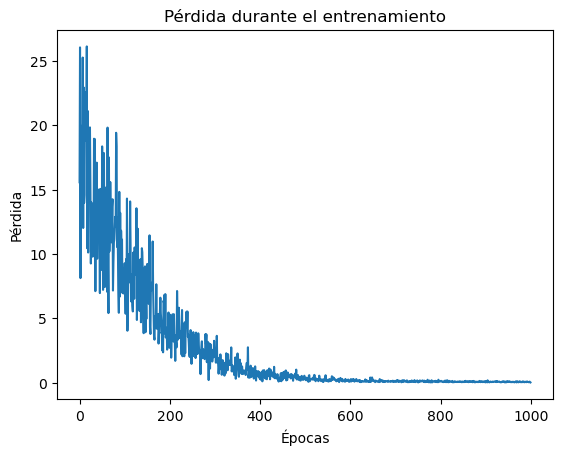

In [16]:
# Compilar el modelo con el optimizador RMSprop y métrica de pérdida
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error')
x = tf.linspace(-1.0, 1.0, 100)# Generar datos de entrada en el rango [-1, 1]
history = model.fit(x, epochs=1000, verbose=0)# Entrenar el modelo durante 500 épocas
import matplotlib.pyplot as plt # Visualizar la pérdida a lo largo de las épocas
plt.plot(history.history["loss"])
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.show()

4/4 [==============================] - 0s 8ms/step


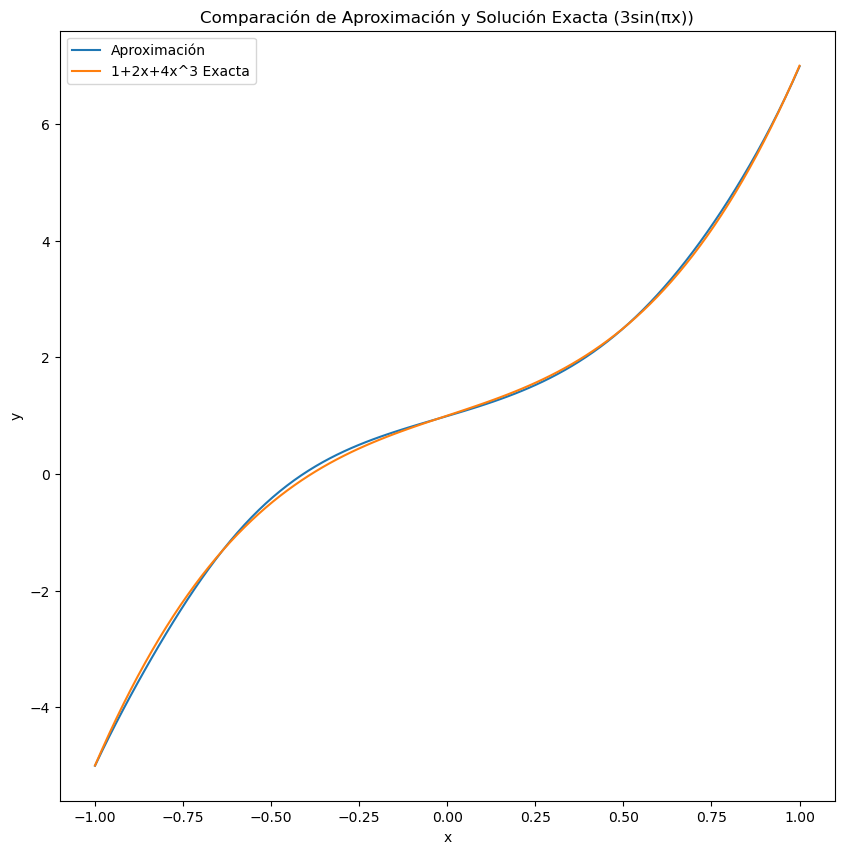

In [17]:
x_testv = tf.linspace(-1,1,100)# Generar datos de prueba en el rango [-1, 1]
a=model.predict(x_testv)# Obtener las predicciones del modelo
exact_solution = 1.+2.*x+4.*x**3# solución exacta

# Graficar las predicciones y la solución exacta
plt.figure(figsize = (10,10))
plt.plot(x_testv, a, label="Aproximación")
plt.plot(x_testv, exact_solution, label="1+2x+4x^3 Exacta")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparación de Aproximación y Solución Exacta (3sin(πx))')
plt.show()